In [1]:
% matplotlib inline

#### Week 3: Baseline Models

In [303]:
import gdal
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

from geotiling import GeoProps
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from skimage.feature import hog, daisy
from skimage import data, color, exposure

gdal.SetCacheMax(2**30) # 1 GB
sns.set_style("white")

**Baseline: regression against night-time light intensity**

In [3]:
!head -n 20 ../data/bucket_files.txt 

total 59951805
-rw-r--r-- 1 tony tony    303032 Oct  9 17:38 Bangladesh_CE_2011.csv
-rw-r--r-- 1 tony tony    338626 Oct  9 17:38 Bangladesh_CE_2015.csv
-rw-r--r-- 1 tony tony 725954782 Oct  9 23:20 F182013.v4c_web.stable_lights.avg_vis.tif
-rw-r--r-- 1 tony tony  18901311 Oct  9 23:17 F182013.v4c_web.stable_lights.avg_vis.tif.gz
-rw-r--r-- 1 tony tony  78403136 Oct  9 17:38 India_pov_pop.csv
-rw-r--r-- 1 tony tony      4785 Oct  9 17:38 Readme_poverty.rtf
-rw-r--r-- 1 tony tony   2276712 Oct  9 17:38 l8_median_bangladesh_2011_multiband_500x500_1.0.tif
-rw-r--r-- 1 tony tony   2282172 Oct  9 17:38 l8_median_bangladesh_2011_multiband_500x500_10.0.tif
-rw-r--r-- 1 tony tony   2339729 Oct  9 17:38 l8_median_bangladesh_2011_multiband_500x500_100.0.tif
-rw-r--r-- 1 tony tony   2264301 Oct  9 17:38 l8_median_bangladesh_2011_multiband_500x500_1000.0.tif
-rw-r--r-- 1 tony tony   2266455 Oct  9 17:38 l8_median_bangladesh_2011_multiband_500x500_1001.0.tif
-rw-r--r-- 1 tony tony   2277458 Oct  9 

In [4]:
bangladesh_2011 = pd.read_csv("../data/bucket/Bangladesh_CE_2011.csv")
bangladesh_2015 = pd.read_csv("../data/bucket/Bangladesh_CE_2015.csv")
india = pd.read_csv("../data/bucket/India_pov_pop.csv")

In [5]:
india_sampled = india[np.logical_and(india["id"] >= 225612, india["id"] <= 254239)]

In [6]:
india_sampled.shape

(28628, 15)

In [7]:
india_sampled.to_csv("../data/india_sampled.csv")

**Separate train/test/validation datasets**

In [306]:
# bangladesh_2015["totexp_m"] = bangladesh_2015["totexp_m"] / 82.42

In [307]:
# shuffled = bangladesh_2015.sample(frac=1.0)

In [308]:
# N = len(shuffled)
# i, j = round(N * 0.75), round(N * 0.9)

# bangladesh_2015_train = shuffled.iloc[:i,:]
# bangladesh_2015_valid = shuffled.iloc[i:j,:]
# bangladesh_2015_test = shuffled.iloc[j:,:]

In [309]:
# bangladesh_2015_train.to_csv("../data/bangladesh_2015_train.csv")
# bangladesh_2015_valid.to_csv("../data/bangladesh_2015_valid.csv")
# bangladesh_2015_test.to_csv("../data/bangladesh_2015_test.csv")

In [8]:
bangladesh_2015_train = pd.read_csv("../data/bangladesh_2015_train.csv")
bangladesh_2015_valid = pd.read_csv("../data/bangladesh_2015_valid.csv")
bangladesh_2015_test = pd.read_csv("../data/bangladesh_2015_test.csv")

**VIIRS dataset**

Resolution: 15 arc-seconds [2x that of DMSP].

Date: 2015.

In [9]:
lights_tif = "../data/bucket/SVDNB_npp_20150101-20151231_75N060E_vcm-orm-ntl_v10_c201701311200.avg_rade9.tif"

In [10]:
viirs_tif = gdal.Open(lights_tif)

In [11]:
viirs_props = GeoProps()
viirs_props.import_geogdal(viirs_tif)

In [12]:
viirs_night_intensities = np.zeros(len(bangladesh_2015))

In [13]:
def visualize_viirs(lng, lat, diameter=32):
  x, y = viirs_props.lonlat2colrow(lng, lat)
  A = viirs_tif.ReadAsArray(x - diameter // 2, y - diameter // 2, diameter, diameter)
  plt.imshow(A.astype("float"));

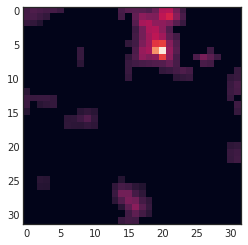

In [14]:
# example of village that isn't at center of image
visualize_viirs(89.877778, 22.840833)

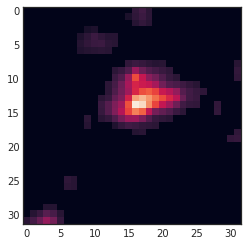

In [15]:
# last week's example image
visualize_viirs(90.1959352984, 22.6341331408)

In [16]:
diameter = 32
for i in range(len(bangladesh_2015)):
  lat = bangladesh_2015["lat"][i]
  lng = bangladesh_2015["long"][i]
  if np.isnan(lat) or np.isnan(lng):
    print("Cannot locate row {}".format(i))
    continue
  x, y = viirs_props.lonlat2colrow(lng, lat)
  patch = viirs_tif.ReadAsArray(x - diameter // 2, y - diameter // 2, diameter, diameter)
  if patch is None:
    print("No entry for row {}".format(i))
  else:
    viirs_night_intensities[i] = np.max(patch)

Cannot locate row 1659
Cannot locate row 2087
No entry for row 2433
No entry for row 5062
No entry for row 5327
No entry for row 5369
No entry for row 5416
No entry for row 5429


In [17]:
df_viirs = pd.concat([pd.Series(viirs_night_intensities, name="viirs"), 
                      bangladesh_2015["totexp_m"],
                      bangladesh_2015["a01"]], axis=1)
df_viirs.set_index("a01");

In [18]:
df_viirs_filt = df_viirs[df_viirs["totexp_m"] > 0]

In [19]:
df_viirs_filt["totexp_m"].corr(df_viirs_filt["viirs"])

0.06870062710309785

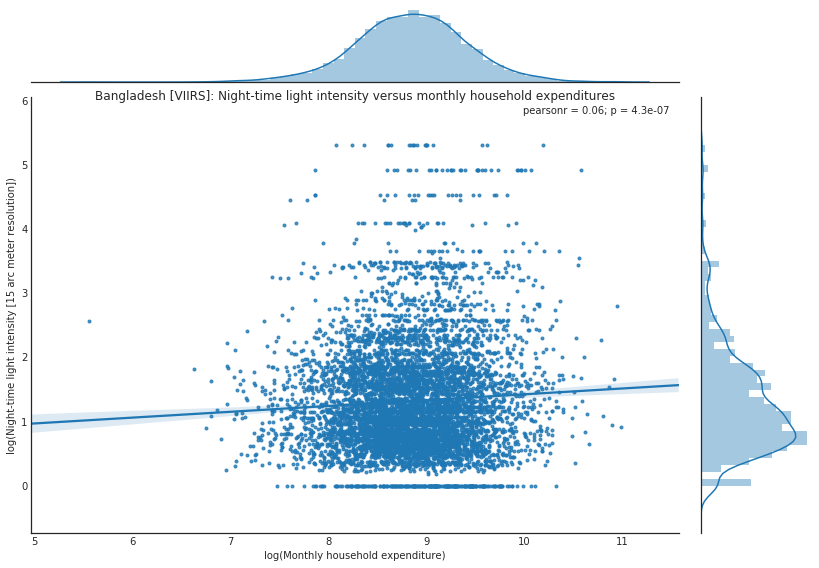

In [47]:
fig = sns.jointplot(np.log(df_viirs_filt["totexp_m"]), np.log(df_viirs_filt["viirs"] + 1), 
                    kind="reg", size=8, marker=".")
fig.fig.set_size_inches((12, 8))
fig.ax_joint.set(ylabel="log(Night-time light intensity [15 arc meter resolution])",
                 xlabel="log(Monthly household expenditure)")
fig.ax_joint.set_title("Bangladesh [VIIRS]: Night-time light intensity versus monthly household expenditures", y=0.98);

**DMSP dataset**

Resolution: 30 arc-seconds.

Date: 2013

In [20]:
lights_tif = "../data/bucket/F182013.v4c_web.stable_lights.avg_vis.tif"

In [21]:
dmsp_tif = gdal.Open(lights_tif)

In [22]:
dmsp_props = GeoProps()
dmsp_props.import_geogdal(dmsp_tif)

In [23]:
dmsp_night_intensities = np.zeros(len(bangladesh_2015))

In [25]:
diameter = 16
for i in range(len(bangladesh_2015)):
  lat = bangladesh_2015["lat"][i]
  lng = bangladesh_2015["long"][i]
  if np.isnan(lat) or np.isnan(lng):
    print("Cannot locate row {}".format(i))
    continue
  x, y = dmsp_props.lonlat2colrow(lng, lat)
  patch = dmsp_tif.ReadAsArray(x - diameter // 2, y - diameter // 2, diameter, diameter)
  if patch is None:
    print("No entry for row {}".format(i))
  else:
    dmsp_night_intensities[i] = np.max(patch)

Cannot locate row 1659
Cannot locate row 2087


In [ ]:
df_dmsp = pd.concat([pd.Series(dmsp_night_intensities, name="dmsp"), 
                     bangladesh_2015["totexp_m"],
                     bangladesh_2015["a01"]], axis=1)
df_dmsp.set_index("a01");

In [27]:
df_dmsp_filt = df_dmsp[df_dmsp["totexp_m"] > 0]

In [28]:
df_dmsp_filt["totexp_m"].corr(df_dmsp_filt["dmsp"])

0.053563728935829065

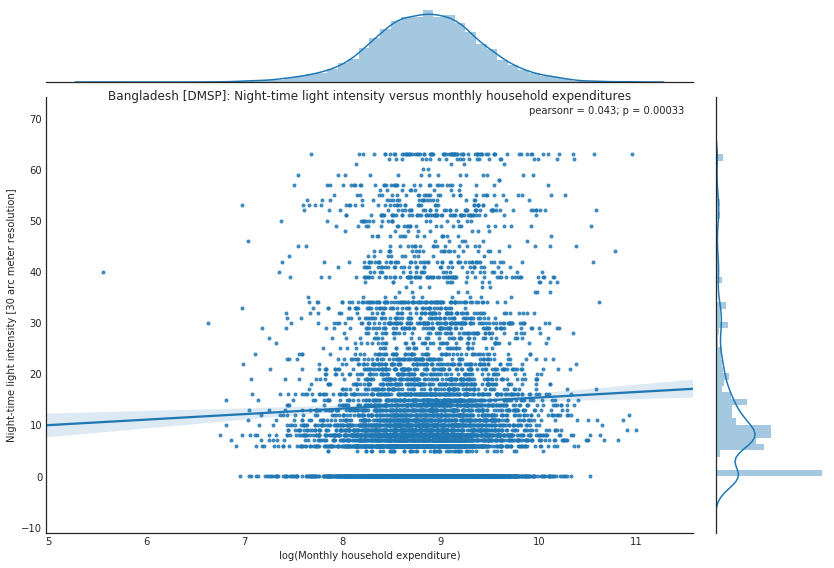

In [87]:
fig = sns.jointplot(np.log(df_dmsp_filt["totexp_m"]), df_dmsp_filt["dmsp"], 
                    kind="reg", size=8, marker=".")
fig.fig.set_size_inches((12, 8))
fig.ax_joint.set(ylabel="Night-time light intensity [30 arc meter resolution]",
                 xlabel="log(Monthly household expenditure)")
fig.ax_joint.set_title("Bangladesh [DMSP]: Night-time light intensity versus monthly household expenditures", y=0.98);

**Baseline -- HOG/Histograms/Night lights**

In [30]:
def load_tiff(hhid, prefix="s1", imgtype="vis", quiet=False):
  """
  hhid:    household index as float [pull from bangladesh_2015 csv]
  prefix:  either "s1" or "l8"
  imgtype: either "vis" or "multiband"
  """
  source_tiff = "../data/bucket/{}_median_bangladesh_{}_500x500_{:.1f}.tif".format(prefix, imgtype, hhid)
  if not quiet:
    print("Loading {}...".format(source_tiff))
  gdal_tif = gdal.Open(source_tiff)
  return gdal_tif.ReadAsArray().astype("uint8")

In [31]:
def vis_tif(A):
  plt.imshow(A.transpose(1,2,0))

In [32]:
A = load_tiff(6170.0, prefix="l8", imgtype="vis")

Loading ../data/bucket/l8_median_bangladesh_vis_500x500_6170.0.tif...


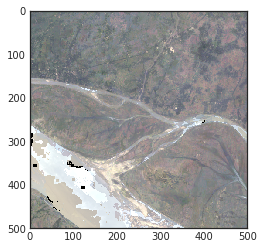

In [384]:
vis_tif(A)

In [563]:
A = load_tiff(6170.0, prefix="l8", imgtype="multiband")

Loading ../data/bucket/l8_median_bangladesh_multiband_500x500_6170.0.tif...


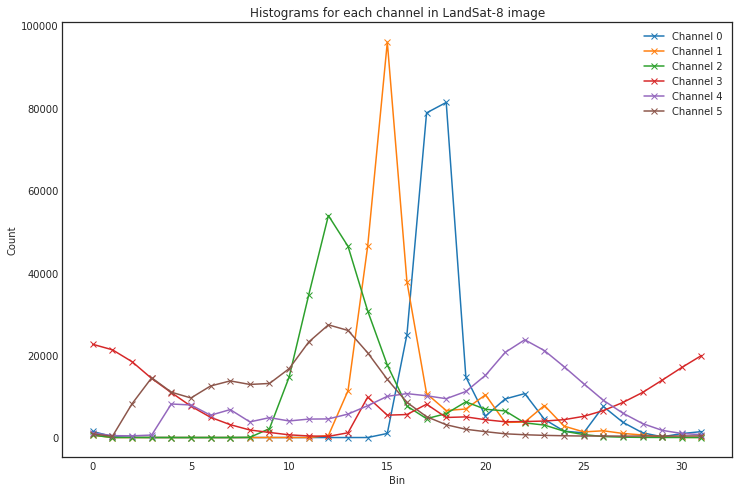

In [564]:
plt.figure(figsize=(12, 8))
for channel_idx in range(6):
  plt.plot(cv2.calcHist(A.astype("uint8"), 
                     channels=[channel_idx], 
                     mask=None, 
                     histSize=[32], 
                     ranges=[0, 256]), "x-", label="Channel {:d}".format(channel_idx))
plt.title("Histograms for each channel in LandSat-8 image")
plt.xlabel("Bin")
plt.ylabel("Count")
plt.legend();

In [582]:
A = load_tiff(6170.0, prefix="s1", imgtype="multiband")

Loading ../data/bucket/s1_median_bangladesh_multiband_500x500_6170.0.tif...


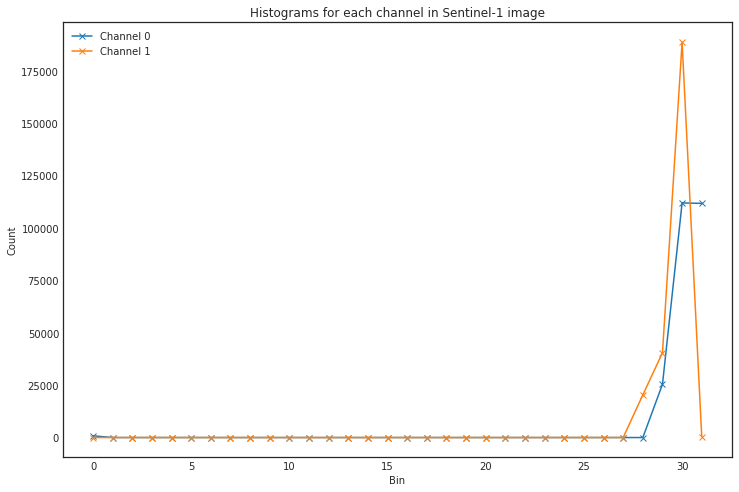

In [588]:
plt.figure(figsize=(12, 8))
for channel_idx in range(2):
  plt.plot(cv2.calcHist(A.astype("uint8"), 
                     channels=[channel_idx], 
                     mask=None, 
                     histSize=[32], 
                     ranges=[0, 256]), "x-", label="Channel {:d}".format(channel_idx))
plt.title("Histograms for each channel in Sentinel-1 image")
plt.xlabel("Bin")
plt.ylabel("Count")
plt.legend();

**Hog features [single-channel]**

In [578]:
A = load_tiff(6170.0, prefix="l8", imgtype="vis")

Loading ../data/bucket/l8_median_bangladesh_vis_500x500_6170.0.tif...


In [579]:
fd = hog(A[0], orientations=8, pixels_per_cell=(16, 16),
        cells_per_block=(1, 1), visualise=True)[0]

/usr/local/lib/python3.5/dist-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


In [580]:
fd, hog_image = hog(A[0], orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualise=True)

/usr/local/lib/python3.5/dist-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


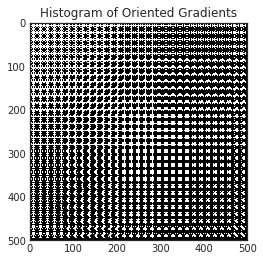

In [581]:
# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 0.02))

# ax2.axis('off')
plt.imshow(hog_image_rescaled, cmap=plt.cm.gray)
plt.title('Histogram of Oriented Gradients');

**Histogram of each channel [LandSat-8]**

Note that we use a resolution of 8 pixel values per histogram bin, for a total of 32 bins per image.

In [44]:
l8_channel_hists = [[] for _ in range(6)]
s1_channel_hists = [[] for _ in range(2)]
hogs = []

In [45]:
error_vect = []

In [ ]:
for i, hhid in enumerate(bangladesh_2015["a01"]):
  if i % 100 == 0:
    print("{}/{} errors.".format(sum(error_vect), i))
  try:
    LM = load_tiff(hhid, prefix="l8", imgtype="multiband", quiet=True)
    SM = load_tiff(hhid, prefix="s1", imgtype="multiband", quiet=True)
    for channel_idx in range(6):
      l8_channel_hists[channel_idx].append(
        cv2.calcHist(LM.astype("uint8"), 
                     channels=[channel_idx], 
                     mask=None, 
                     histSize=[32], 
                     ranges=[0, 256]))
    for channel_idx in range(2):
      s1_channel_hists[channel_idx].append(
        cv2.calcHist(SM.astype("uint8"), 
                     channels=[channel_idx], 
                     mask=None, 
                     histSize=[32], 
                     ranges=[0, 256]))
    hogs.append(hog(SM[0], orientations=8, pixels_per_cell=(16, 16),
                cells_per_block=(1, 1), visualise=True)[0])
    error_vect.append(False)
  except:
    error_vect.append(True)

0/0 errors.


/usr/local/lib/python3.5/dist-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


0/100 errors.
0/200 errors.
8/300 errors.
53/400 errors.
53/500 errors.
53/600 errors.
53/700 errors.
53/800 errors.
53/900 errors.
85/1000 errors.
104/1100 errors.
108/1200 errors.
128/1300 errors.
128/1400 errors.
128/1500 errors.
159/1600 errors.
160/1700 errors.
160/1800 errors.
160/1900 errors.
160/2000 errors.
194/2100 errors.
194/2200 errors.
194/2300 errors.
194/2400 errors.
196/2500 errors.
198/2600 errors.
243/2700 errors.
245/2800 errors.
292/2900 errors.
292/3000 errors.
310/3100 errors.
322/3200 errors.
326/3300 errors.


In [50]:
error_vect = pd.Series(error_vect)

In [53]:
np.sum(error_vect)

783

Construct $X$ and $Y$ data and partition into train/test/valid.

In [269]:
X = np.c_[np.hstack(np.hstack(l8_channel_hists)).T, 
          np.hstack(np.hstack(s1_channel_hists)).T, 
          hogs, 
          viirs_night_intensities[error_vect == False],
          dmsp_night_intensities[error_vect == False]]

In [270]:
X = pd.DataFrame(X)

In [271]:
y = bangladesh_2015
y = y[error_vect == False]

In [272]:
X = X.assign(a01=pd.Series(y["a01"]).values)

In [273]:
X.shape, y.shape

((6532, 7947), (6532, 6))

In [274]:
X_train = X[np.in1d(X["a01"], bangladesh_2015_train["a01"])]
y_train = y[np.in1d(y["a01"], bangladesh_2015_train["a01"])]

In [275]:
X_valid = X[np.in1d(X["a01"], bangladesh_2015_valid["a01"])]
y_valid = y[np.in1d(y["a01"], bangladesh_2015_valid["a01"])]

In [276]:
y_train = y_train["totexp_m"]
y_valid = y_valid["totexp_m"]

In [277]:
X_train.shape, y_train.shape

((4913, 7947), (4913,))

Ridge regression: hyperparamter search.

In [440]:
for alpha in np.logspace(0, 5, num=6):
  lm = Ridge(alpha=alpha, normalize=True)
  lm.fit(X_train, y_train)
  print(alpha, lm.score(X_valid, y_valid))

1.0 -0.121578790692
10.0 0.0389240786255
100.0 0.0268516546093
1000.0 0.00765367236894
10000.0 0.000403408092062
100000.0 -0.000543028093194


In [442]:
lm = Ridge(alpha=20, normalize=True)
lm.fit(X_train, y_train)

Ridge(alpha=20, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=True, random_state=None, solver='auto', tol=0.001)

In [443]:
lm.score(X_train, y_train)

0.15370625432000695

In [444]:
lm.score(X_valid, y_valid)

0.038943488007046723

In [445]:
y_pred = lm.predict(X_valid)

In [446]:
np.sqrt(np.mean(np.square(y_pred - y_valid)))

4930.1686486960016

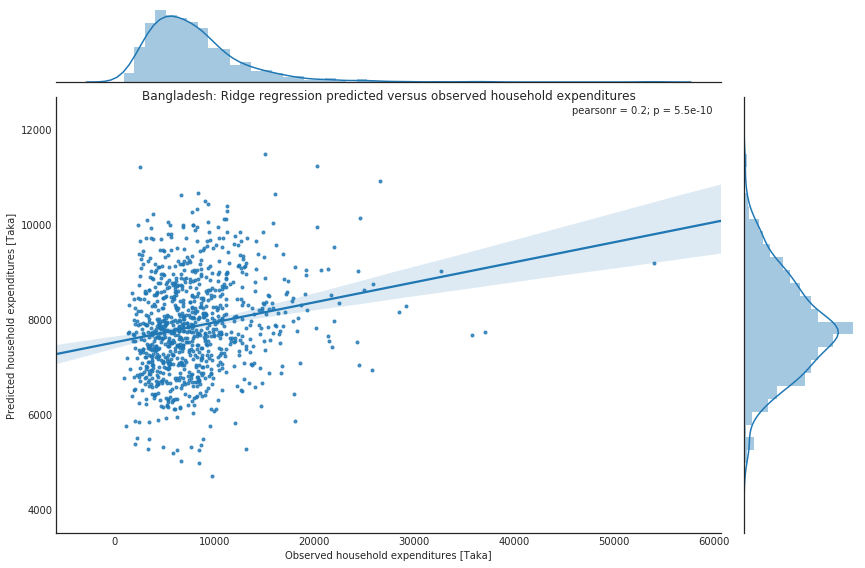

In [424]:
fig = sns.jointplot(y_valid[np.logical_and(y_valid > 0, y_pred > 0)], 
                    y_pred[np.logical_and(y_valid > 0, y_pred > 0)], 
                    kind="reg", size=8, marker=".")
fig.fig.set_size_inches((12, 8))
fig.ax_joint.set(ylabel="Predicted household expenditures [Taka]",
                 xlabel="Observed household expenditures [Taka]")
fig.ax_joint.set_title("Bangladesh: Ridge regression predicted versus observed household expenditures", y=0.98);

Lasso regression.

In [394]:
lm = Lasso(alpha=1200.0)

In [395]:
lm.fit(X_train, y_train)

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Lasso(alpha=1200.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [396]:
lm.score(X_train, y_train)

0.10488938994692287

In [397]:
lm.score(X_valid, y_valid)

0.028151352015512776

In [399]:
y_pred = lm.predict(X_valid)

In [400]:
np.sqrt(np.mean(np.square(y_pred - y_valid)))

4957.7729108895837

Random forest regression.

In [370]:
rf = RandomForestRegressor(criterion="mae", max_depth=50, n_estimators=100, n_jobs=4)

In [371]:
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mae', max_depth=50,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=4,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [450]:
rf.score(X_train, y_train)

0.8066059966865724

In [447]:
rf.score(X_valid, y_valid)

-0.061795698311887019

In [448]:
y_pred = rf.predict(X_valid)

In [449]:
np.sqrt(np.mean(np.square(y_pred - y_valid)))

5182.123913879178